<a id=top-page></a>

# `pykitPIV` demo: Create a **PyTorch** data loader for **pykitPIV**-generated images

In this Jupyter notebook, we  create a **PyTorch**-compatible data loader for **pykitPIV**-generated PIV images
that can be readily used for training ML algorithms. We use the ``PIVDataset`` class from the ``ml`` module
which is a subclass of **PyTorch**'s ``torch.utils.data.Dataset``.
We then use **PyTorch**'s ``torch.utils.data.DataLoader`` to handle loading training and testing samples.
You can learn more about the methodology of using datasets and data loaders
[in this PyTorch documentation](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

<div class="alert alert-block alert-info" style="margin-top: 20px">
<font size="3"><strong>Table of contents:</strong></font>
<br>
<ol>
    <li><a href="#PIVDataset-class">The PIVDataset class </a></li>
    <li><a href="#upload-images">Upload pykitPIV-generated images </a></li>
</ol>
<p></p>
</div>
<br>

***

In [3]:
import numpy as np
import h5py
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import cmcrameri.cm as cmc

In [ ]:
save_images = False
filename = None

<a id=PIVDataset-class></a>

***

## The ``PIVDataset`` class

[Go to the top](#top-page)

**pykitPIV** provides the ``PIVDataset`` class that is a subclass of the ``torch.utils.data.Dataset`` class.
It implements three standard methods: ``__init__``, ``__len__``, and ``__getitem__``. Below, we present the content
of this class which can be readily accessed from the ``ml`` module:


In [4]:
class PIVDataset(Dataset):

    def __init__(self, dataset, transform=None):

        if isinstance(dataset, str):

            # Upload the dataset:
            f = h5py.File(dataset, "r")

            # Access image intensities:
            self.data = np.array(f["I"]).astype("float32")

            # Access flow targets:
            self.target = np.array(f["targets"]).astype("float32")

        elif isinstance(dataset, dict):

            # Access image intensities:
            self.data = np.array(dataset["I"]).astype("float32")

            # Access flow targets:
            self.target = np.array(dataset["targets"]).astype("float32")

        # Multiply the v-component of velocity by -1:
        self.target[:,1,:,:] = -self.target[:,1,:,:]

        if isinstance(dataset, str): f.close()

        # Allow for any custom data transforms to be used later:
        self.transform = transform

    def __len__(self):

        return len(self.data)

    def __getitem__(self, idx):

        # Get the sample:
        sample = self.data[idx], self.target[idx]

        # Apply any custom data transforms on this sample:
        if self.transform:
            sample = self.transform(sample)

        return sample

<a id=create-dataloaders></a>

***

## Create **PyTorch**-compatible data loaders for **pykitPIV** images

[Go to the top](#top-page)

<a id=upload-images></a>

### Upload **pykitPIV**-generated images 

[Go to the top](#top-page)

We assume that the PIV/BOS images have been saved and are stored under the following ``path``:


In [5]:
path = '../docs/data/pykitPIV-dataset-10-PIV-pairs-256-by-256.h5'

If you don't have the desired PIV/BOS dataset yet, you can use the generic script,
``/scripts/pykitPIV-generate-images.py``, and run it with, e.g.:

```
python pykitPIV-generate-images.py --n_images 10 --size_buffer 10 --image_height 256 --image_width 256
```

We instantiate an object of the ``PIVDataset`` class:

In [6]:
PIV_data = PIVDataset(dataset=path)

Thanks to the ``__len__`` method, we can now execute the ``len()`` command on the object. This will return the total number of PIV image pairs in the uploaded dataset.

In [7]:
len(PIV_data)

10

Thanks to the ``__getitem__`` method, we can access the data sample at a given index:


In [8]:
(I, target) = PIV_data[2]

In [9]:
I.shape

(2, 256, 256)

In [10]:
target.shape

(2, 256, 256)

or, at multiple indices:

In [11]:
(I, target) = PIV_data[2:7]

You can use the indexing to visualize the first few samples from the dataset:

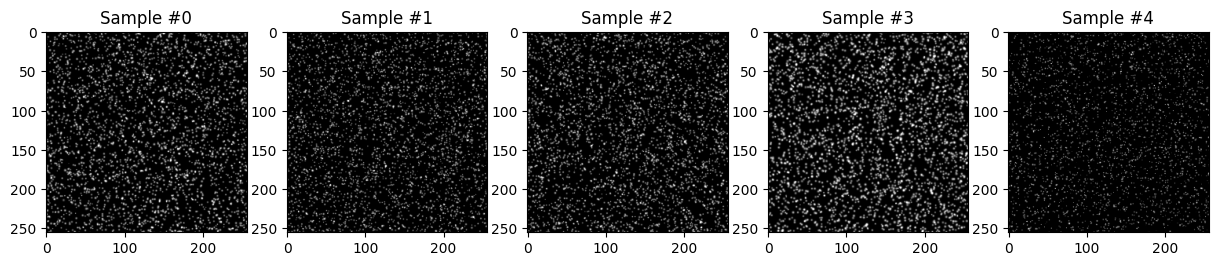

In [12]:
n_samples = 5

fig = plt.figure(figsize=(n_samples*3, 5))
spec = fig.add_gridspec(ncols=n_samples, 
                        nrows=1, 
                        width_ratios=[1 for i in range(0,n_samples)], 
                        height_ratios=[1])

for i in range(0,n_samples):
    I, target = PIV_data[i]
    f = fig.add_subplot(spec[0,i])
    plt.imshow(I[0,:,:], cmap='Greys_r')
    plt.title('Sample #' + str(i))

# plt.savefig('PIV-samples.png', dpi=300, bbox_inches='tight')

<a id=create-dataloader></a>

### Create a ``torch.utils.data.DataLoader`` with train and test samples

[Go to the top](#top-page)

First, we allow the user to create custom composition of data transforms that will augment the
train and test datasets. For more information on data transforms check this link
`this link <https://pytorch.org/vision/stable/transforms.html>`_.

In [13]:
transform = None

In [14]:
transform = transforms.ToTensor()

In [15]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.RandomHorizontalFlip(p=0.5)])

Next, we create train and test datasets using an instance of ``PIVDataset`` for each.

The first method assumes that you have a separate file for the train and test samples:

In [19]:
path_train = '../docs/data/pykitPIV-dataset-10-PIV-pairs-256-by-256.h5'
path_test = '../docs/data/pykitPIV-dataset-10-PIV-pairs-256-by-256.h5'

therefore, you can create:

In [20]:
train_dataset = PIVDataset(dataset=path_train, transform=transform)
test_dataset = PIVDataset(dataset=path_test, transform=transform)

The second method is to upload the dataset dictionary directly, assuming that you have one containing training and
one containing testing samples. This gives the user a chance for a more flexible train/test split. Note that the
dictionary has to store image intensities under the key ``"I"`` and image targets under the key ``"targets"``.

In [21]:
dataset_train = {"I" : ... ,
                 "targets" : ...}
dataset_test = {"I" : ... ,
                "targets" : ...}

In an analogous way, you can create:

In [22]:
train_dataset = PIVDataset(dataset=dataset_train, transform=transform)
test_dataset = PIVDataset(dataset=dataset_test, transform=transform)

TypeError: float() argument must be a string or a real number, not 'ellipsis'

In [14]:
train_dataset = PIVDataset(path=path, transform=transform)
test_dataset = PIVDataset(path=path, transform=transform)

In [15]:
(I, target) = train_dataset[0]

(2, 256, 256)
torch.Size([256, 2, 256])


In [16]:
I.shape

torch.Size([256, 2, 256])

In [17]:
target.shape

torch.Size([256, 2, 256])

Finally, we create **PyTorch** data loaders for train and test samples. There, we have the option to specify
various mini-batching parameters such as the the batch size.
You can check all the available arguments of ``torch.utils.data.DataLoader``
`here <https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader>`_.


In [18]:
# Create train and test data loaders:
train_loader = DataLoader(train_dataset,
                      batch_size=5,
                      shuffle=True)

test_loader = DataLoader(test_dataset,
                     batch_size=5,
                     shuffle=True)

In [19]:
train_I, train_targets = next(iter(train_loader))

(2, 256, 256)
torch.Size([256, 2, 256])
(2, 256, 256)
torch.Size([256, 2, 256])
(2, 256, 256)
torch.Size([256, 2, 256])
(2, 256, 256)
torch.Size([256, 2, 256])
(2, 256, 256)
torch.Size([256, 2, 256])


In [20]:
train_I.shape

torch.Size([5, 256, 2, 256])

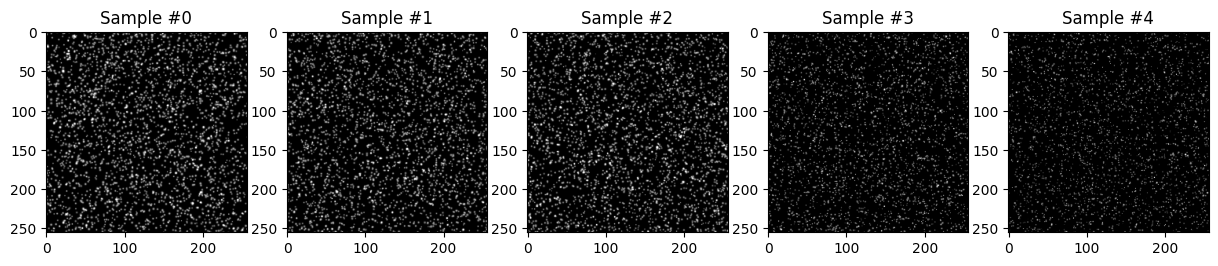

In [21]:
n_samples = 5

fig = plt.figure(figsize=(n_samples*3, 5))
spec = fig.add_gridspec(ncols=n_samples, 
                        nrows=1, 
                        width_ratios=[1 for i in range(0,n_samples)], 
                        height_ratios=[1])

for i in range(0,n_samples):
    
    f = fig.add_subplot(spec[0,i])
    plt.imshow(train_I[i,:,0,:], cmap='Greys_r')
    plt.title('Sample #' + str(i))

# plt.savefig('PIV-samples.png', dpi=300, bbox_inches='tight')

***

© K. Zdybał, C. Mucignat, S. Kunz, I. Lunati (2025)